In [1]:
import graph_tool.all as gt
import sys, os
import graph_embeddings
from utils.score import statistical_parity
import faiss
import residual2vec as rv
import numpy as np
import pandas as pd
from scipy import sparse
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx

from sklearn.neighbors import kneighbors_graph
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder


DATA_FILE = 'data/polbooks.gml'
G = nx.read_gml(DATA_FILE)
G = nx.relabel.convert_node_labels_to_integers(G, first_label=0, ordering='default')

nodes = G.nodes(data=True)
labels, group_ids = np.unique([n[1]['value'] for n in nodes], return_inverse=True)

A = nx.adjacency_matrix(G).asfptype()
deg = np.array(A.sum(axis=1)).reshape(-1)
G = nx.from_scipy_sparse_matrix(A)

models = {}
window_length = 5
num_walks = 10
dim = 128

models["unbiased"] = graph_embeddings.DeepWalk(window_length=window_length, num_walks=num_walks, restart_prob=0)

models["degree-unbiased"] = rv.residual2vec_sgd(
    noise_sampler=rv.ConfigModelNodeSampler(),
    window_length=window_length,
    num_walks=num_walks,
    cuda=True,
    walk_length=80
)

models["group-unbiased"] = rv.residual2vec_sgd(
    noise_sampler=rv.SBMNodeSampler(
        group_membership=group_ids, window_length=window_length,
    ),
    window_length=window_length,
    num_walks=num_walks,
    cuda=True,
    walk_length=80,
)

models["fairwalk"] = graph_embeddings.Fairwalk(window_length=window_length, num_walks=num_walks)
models["fairwalk-group-unbiased"] = graph_embeddings.Fairwalk(
    window_length=window_length, num_walks=num_walks, group_membership=group_ids
)
models['GCN'] = graph_embeddings.GCN()
models["gcn-doubleK"] = graph_embeddings.GCN(num_default_features=dim * 2)
models["graphsage"] = graph_embeddings.GraphSage()
models["graphsage-doubleK"] = graph_embeddings.GraphSage(num_default_features=dim * 2)
models["gat"] = graph_embeddings.GAT(layer_sizes=[64, 256])
models["gat-doubleK"] = graph_embeddings.GAT(num_default_features=dim * 2)
embs = {}
for k, model in models.items():
    print(model.__class__.__name__)
    sys.stdout = open(os.devnull, 'w')
    emb = model.fit(A).transform(dim=dim)
    sys.stdout = sys.__stdout__
    embs[k] = emb


def reconstruct_graph(emb, n, m):
    # choose top m edges to reconstruct the graph
    S = emb @ emb.T
    S = np.triu(S, k=1)
    r, c, v = sparse.find(S)
    idx = np.argsort(-v)[:m]
    r, c, v = r[idx], c[idx], v[idx]
    B = sparse.csr_matrix((v, (r, c)), shape=(n, n))
    B = B + B.T
    B.data = B.data * 0 + 1
    return nx.from_scipy_sparse_matrix(B + B.T)

n_edges = int(A.sum() / 2)
n_nodes = A.shape[0]
rgraphs = {}
for k, emb in embs.items():
    rgraphs[k] = reconstruct_graph(emb, n_nodes, n_edges)
    print(type(rgraphs[k]))

2022-07-29 22:52:44.734925: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-29 22:52:44.735086: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-29 22:52:44.736111: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


DeepWalk
residual2vec_sgd


100%|██████████| 329/329 [00:00<00:00, 440.29it/s, loss=1.07] 


residual2vec_sgd


100%|██████████| 329/329 [00:00<00:00, 475.72it/s, loss=1.33]


Fairwalk
Fairwalk
GCN
Using GCN (local pooling) filters...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team

2022-07-29 22:52:51.304812: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-07-29 22:52:51.325038: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2304000000 Hz


Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 0.0099 - val_loss: 0.0098
Epoch 2/200
1/1 [==============================] - 0s 245ms/step - loss: 0.0096 - val_loss: 0.0098
Epoch 3/200
1/1 [==============================] - 0s 254ms/step - loss: 0.0094 - val_loss: 0.0098
Epoch 4/200
1/1 [==============================] - 0s 230ms/step - loss: 0.0093 - val_loss: 0.0098
Epoch 5/200
1/1 [==============================] - 0s 300ms/step - loss: 0.0092 - val_loss: 0.0098
Epoch 6/200
1/1 [==============================] - 0s 207ms/step - loss: 0.0092 - val_loss: 0.0098
Epoch 7/200
1/1 [==============================] - 0s 301ms/step - loss: 0.0091 - val_loss: 0.0098
Epoch 8/200
1/1 [==============================] - 0s 277ms/step - loss: 0.0091 - val_loss: 0.0098
Epoch 9/200
1/1 [==============================] - 0s 276ms/step - loss: 0.0089 - val_loss: 0.0098
Epoch 10/200
1/1 [==============================] - 0s 310ms/step - loss: 0.0090 - val_loss: 0.0098
Epoch 11/200

In [3]:
scores = {}
for k, graph in rgraphs.items():
    scores[k] = statistical_parity(graph, group_ids)
    print("class score: ", k, scores[k])

100%|██████████| 3/3 [00:00<00:00, 2409.60it/s]


class score:  unbiased 0.1464518608790001


100%|██████████| 3/3 [00:00<00:00, 2252.18it/s]


class score:  degree-unbiased 0.15604094802988733


100%|██████████| 3/3 [00:00<00:00, 2871.50it/s]


class score:  group-unbiased 0.10059361653570019


100%|██████████| 3/3 [00:00<00:00, 2455.68it/s]


class score:  fairwalk 0.1488161993482154


100%|██████████| 3/3 [00:00<00:00, 3033.49it/s]


class score:  fairwalk-group-unbiased 0.14965895096260692


100%|██████████| 3/3 [00:00<00:00, 2572.14it/s]


class score:  GCN 0.13534382882098314


100%|██████████| 3/3 [00:00<00:00, 3206.65it/s]


class score:  gcn-doubleK 0.17245112321517442


100%|██████████| 3/3 [00:00<00:00, 3929.70it/s]


class score:  graphsage 0.08425043288877315


100%|██████████| 3/3 [00:00<00:00, 3029.84it/s]


class score:  graphsage-doubleK 0.09101280073146133


100%|██████████| 3/3 [00:00<00:00, 3574.69it/s]


class score:  gat 0.10835415863751031


100%|██████████| 3/3 [00:00<00:00, 3974.39it/s]

class score:  gat-doubleK 0.07656589674549143


[Text(0,0,'unbiased'),
 Text(0,0,'degree-unbiased'),
 Text(0,0,'group-unbiased'),
 Text(0,0,'fairwalk'),
 Text(0,0,'fairwalk-group-unbiased'),
 Text(0,0,'GCN'),
 Text(0,0,'gcn-doubleK'),
 Text(0,0,'graphsage'),
 Text(0,0,'graphsage-doubleK'),
 Text(0,0,'gat'),
 Text(0,0,'gat-doubleK')]

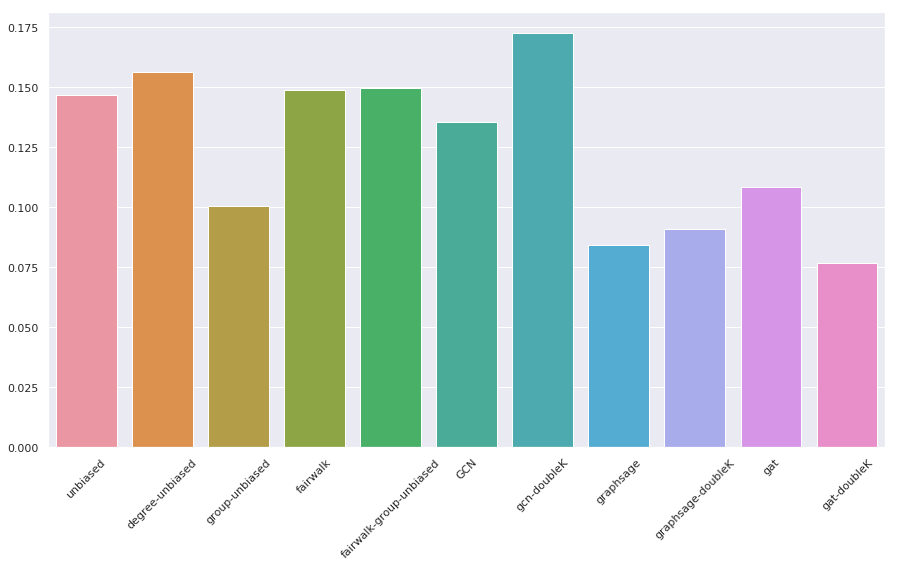

In [6]:
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(scores.keys()), y=list(scores.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)